In [ ]:
import os
import numpy as np
import pandas as pd
import sklearn
import glob
import librosa
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import seaborn as sn
import matplotlib.pyplot as plt
## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
!pip install keras.utils
import keras.utils
!pip install tensorflow
import tensorflow
#from keras.utils import to_categorical

  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=4d2f30c0a23d15a56f168e4cbbbc65b6c9d5804e2c0419b40e633078cbae1b9e
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#labels = ["angry", "disgusted", "fearful", "happy", "neutral", "sad"]
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fear',
  '07':'disgust',
  '08':'surprised'
}


observed_emotions = ['sad','angry','happy','disgust','neutral','fear']

In [ ]:
import zipfile
#if not os.path.isdir("/content/drive/MyDrive/ryerson"):
with zipfile.ZipFile("/content/drive/MyDrive/CS464 Project/Datasets/ryerson.zip","r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive") 

In [ ]:
#if not os.path.isdir("/content/drive/MyDrive/toronto"):
with zipfile.ZipFile("/content/drive/MyDrive/CS464 Project/Datasets/toronto.zip","r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive") 

In [ ]:
def extract_feature(file_name, mfcc):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((mfccs))
    return result

In [ ]:
def load_data(test_size=0.2): 
    x,y=[],[]
    
    # feature to extract
    mfcc = True

    for file in os.listdir("/content/drive/MyDrive/ryerson"):
        path = "/content/drive/MyDrive/ryerson/"
        file_name = path+file
        for audio in os.listdir(file_name):
            audio_file = file_name + "/" + audio
            emotion=emotions[audio_file.split("-")[2]] #to get emotion according to filename. dictionary emotions is defined above.
            if emotion not in observed_emotions: #options observed_emotions - RAVDESS and TESS, ravdess_emotions for RAVDESS only
                continue
            feature=extract_feature(audio_file, mfcc)
            x.append(feature)
            y.append(emotion)
        

    for file in os.listdir("/content/drive/MyDrive/toronto/TESS Toronto emotional speech set data"):
        path = "/content/drive/MyDrive/toronto/TESS Toronto emotional speech set data/"
        file_name = path+file
        for audio in os.listdir(file_name):
            audio_file = file_name + "/" + audio
            emotion=audio.split("_")[2][:-4] #split and remove .wav
            if emotion not in observed_emotions: #options observed_emotions - RAVDESS and TESS, ravdess_emotions for RAVDESS only
                continue
            feature=extract_feature(audio_file, mfcc)
            x.append(feature)
            y.append(emotion)
  

    return {"X":x,"y":y}

In [ ]:
Trial_dict = load_data(test_size = 0.3)

In [ ]:
Trial_dict

{'X': [array([-5.92968567e+02,  5.58934746e+01, -1.98367195e+01,  1.55365601e+01,
         -4.79433775e+00, -3.64649504e-01, -1.60151844e+01, -4.50567484e+00,
         -2.24467583e+01, -5.30258560e+00, -3.21678495e+00, -6.32575512e+00,
         -4.76676750e+00, -5.82967901e+00, -4.81415796e+00,  3.50686502e+00,
         -1.29739075e+01, -5.67043638e+00, -3.69170976e+00, -5.06036997e+00,
         -8.07241917e+00, -2.19161320e+00, -7.27878523e+00, -8.18174076e+00,
         -1.57333159e+00, -6.39131069e+00, -5.86956406e+00, -2.21247792e+00,
         -6.18055248e+00, -4.14034414e+00, -5.83365774e+00, -6.58000660e+00,
         -2.47147250e+00, -3.67945337e+00, -3.85655463e-01,  1.37049747e+00,
          5.21270895e+00,  4.10505962e+00,  8.52840614e+00,  1.16430235e+01],
        dtype=float32),
  array([-5.7227014e+02,  5.4515331e+01, -2.0434851e+01,  1.5288507e+01,
         -3.7721050e+00, -1.7467765e+00, -1.6040491e+01, -3.8343241e+00,
         -2.1938566e+01, -8.5506743e-01, -3.4510577e+0

In [ ]:
X = pd.DataFrame(Trial_dict["X"])
y = pd.DataFrame(Trial_dict["y"])

In [ ]:
#renaming the label column to emotion
y=y.rename(columns= {0: 'emotion'})

In [ ]:
data = pd.concat([X, y], axis =1)
data = data.reindex(np.random.permutation(data.index))
data.to_csv("RAVTESS_MFCC_Observed.csv")

In [ ]:
data = pd.read_csv("RAVTESS_MFCC_Observed.csv")

In [ ]:
data.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', 'emotion'],
      dtype='object')

In [ ]:
#dropping the column Unnamed: 0 to removed shuffled index
data = data.drop('Unnamed: 0',axis=1)

In [ ]:
#separating features and target outputs
X = data.drop('emotion', axis = 1).values
y = data['emotion'].values

In [ ]:
np.unique(y)

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

SVM

In [ ]:
svclassifier = SVC(kernel = 'linear') #can be tried with other kernel functions???????????????

In [ ]:
y_train.shape

(2582,)

In [ ]:
X_train.shape

(2582, 40)

In [ ]:
starting_time = time.time()
svclassifier.fit(X_train, y_train)
print("Trained model in %s ms " % str(time.time() - starting_time))

Trained model in 16.549915075302124 ms 


In [ ]:
y_pred = svclassifier.predict(X_test)

              precision    recall  f1-score   support

       angry       0.79      0.86      0.82       111
     disgust       0.87      0.99      0.93        69
        fear       0.82      0.84      0.83       115
       happy       0.87      0.80      0.83       129
     neutral       0.98      0.96      0.97       102
         sad       0.93      0.84      0.88       120

    accuracy                           0.87       646
   macro avg       0.88      0.88      0.88       646
weighted avg       0.87      0.87      0.87       646

----accuracy score 87.15170278637771 ----


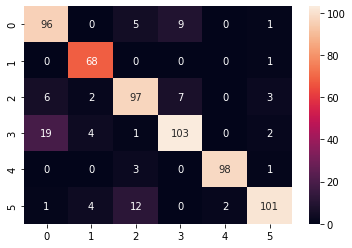

In [ ]:
print(classification_report(y_test,y_pred))

acc = float(accuracy_score(y_test,y_pred))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

In [ ]:
test_acc = float(svclassifier.score(X_test, y_test)*100)
print("----test accuracy score %s ----" % test_acc)

----test accuracy score 87.15170278637771 ----


CROSS VALIDATION

In [ ]:
# no. of folds cv = 5
cv_results = cross_val_score(svclassifier, X, y, cv = 5)
print(cv_results)

[0.88854489 0.86068111 0.90247678 0.87906977 0.88217054]


In [ ]:
#splitting dataset into train/ test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('SVM', SVC())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set: svc_scaled
svc_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a classifier to the unscaled data
svc_unscaled = SVC(kernel = 'linear').fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(svc_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(svc_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.9690402476780186
Accuracy without Scaling: 0.8947368421052632


In [ ]:
train_acc = float(svc_scaled.score(X_train, y_train)*100)
print("----train accuracy score %s ----" % train_acc)

test_acc = float(svc_scaled.score(X_test, y_test)*100)
print("----test accuracy score %s ----" % test_acc)

----train accuracy score 98.02478698683191 ----
----test accuracy score 96.90402476780186 ----


In [ ]:
scaled_predictions = svc_scaled.predict(X_test)

              precision    recall  f1-score   support

       angry       0.99      0.97      0.98       123
     disgust       1.00      1.00      1.00        85
        fear       0.94      0.88      0.91       106
       happy       1.00      1.00      1.00       128
     neutral       1.00      1.00      1.00        88
         sad       0.90      0.97      0.93       116

    accuracy                           0.97       646
   macro avg       0.97      0.97      0.97       646
weighted avg       0.97      0.97      0.97       646

----accuracy score 96.90402476780186 ----


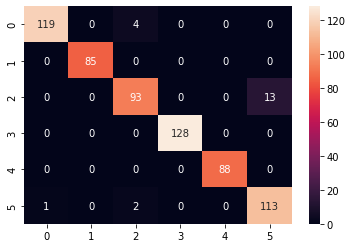

In [ ]:
print(classification_report(y_test,scaled_predictions))

acc = float(accuracy_score(y_test,scaled_predictions))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(y_test,scaled_predictions)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

In [ ]:
# no. of folds cv = 5
cv_results = cross_val_score(svc_scaled, X, y, cv = 5)
print(cv_results)

[0.96439628 0.96594427 0.97832817 0.9627907  0.9627907 ]


In [ ]:
# Burayı görmezden gelin
steps = [('scaler', StandardScaler()), ('SVM', SVC(kernel="poly"))]
pipeline = Pipeline(steps)
svc_scaled = pipeline.fit(X_train, y_train)

print('Accuracy: {}'.format(svc_scaled.score(X_test, y_test)))


Accuracy: 0.9504643962848297
